# Import Statements #

In [41]:
import numpy as np
#from numba import cuda
import matplotlib.pyplot as plt
from numpy import random
from multiprocessing.pool import ThreadPool as Pool
import time


# Classes #

In [42]:
#parent class for animals
class Animal:
  def __init__ (self,id, hungerRate, birthRate, currLife, moveSpeed, speedModifier, rowPosition, columnPosition):
    self.id=id
    self.hungerRate=hungerRate
    self.birthRate=birthRate
    self.currLife=currLife
    self.moveSpeed=moveSpeed
    self.speedModifier=speedModifier
    self.rowPosition=rowPosition
    self.columnPosition=columnPosition
    
    #adjacent tiles at any given spot
    self.moveOptions = [[-1,-1],[0,-1],[1,-1],[-1,0],[1,0],[-1,1],[0,1],[1,1]]
    

  def die(self,Grid,thisarr,otherarr):
    # print("There is death")
    #remove from grid and remove from the list
    setattr(Grid[self.rowPosition][self.columnPosition], "myAnimal", None)
    thisarr = np.delete(thisarr , self.id)
    returnlist = [Grid,thisarr,otherarr]
    return returnlist
    
  def breed(self,Grid,numRows, numCols,animalArr,otherArr):
    #moved into one of our own and TotalPopuation < MaxPopulation - 1
    #spawn new animalType in free adjacent cell
    #breed chance
    toBirth = False

    rand = random.random()

    if rand<=self.birthRate:
      toBirth = True

    #spawn child
    if (toBirth):

      moveOptionsCopy = self.moveOptions.copy()
      validMoveOptions = moveOptionsCopy.copy()
      count = 0

      
      #remove invalid moves from validMoveOptions
      for i in moveOptionsCopy:
        xpos = i[0]
        ypos = i[1]
        
        #if the adjacent cell is out of bounds then remove that from option
        if self.rowPosition + xpos <= -1 or self.rowPosition + xpos >= numRows or self.columnPosition + ypos <= -1 or self.columnPosition + ypos >= numCols:
          validMoveOptions.pop(count) 
          continue
        #if the adjacent cell is occupied
        if getattr(Grid[self.rowPosition+xpos][self.columnPosition+ypos],'myAnimal') != None:
          validMoveOptions.pop(count)
          continue
        count += 1
      
      if (len(validMoveOptions)>0):  
        BirthOption = random.randint(len(validMoveOptions))

       
        Move = validMoveOptions[BirthOption]

        deltaX = self.rowPosition + Move[0]
        deltaY = self.columnPosition + Move[1]

        # print (f"I'm breeding to {deltaX}, {deltaY}")

        if type(self).__name__ == "Wolf":
          #spawn new wolf
          newID = len(animalArr)
          babyWolf = Wolf(newID,self.hungerRate,self.birthRate,self.currLife,self.moveSpeed,self.speedModifier,deltaX,deltaY)
          setattr(Grid[deltaX][deltaY], 'myAnimal', babyWolf)
          animalArr = np.append(animalArr, babyWolf)
          returnList = [Grid,animalArr,otherArr]
          return returnList
        else :
          #spawn new sheep
          newID = len(animalArr)
          babySheep = Sheep(newID,self.hungerRate,self.birthRate,self.currLife,self.moveSpeed,self.speedModifier,deltaX,deltaY)
          animalArr = np.append(animalArr,babySheep)
          setattr(Grid[deltaX][deltaY], 'myAnimal', babySheep)
          returnList = [Grid,animalArr,otherArr]
          return returnList
      else:
        #there is no available space to breed to
        returnList = [Grid,animalArr,otherArr]
        return returnList

  def move(self, Grid, xBound, yBound,thisarr,otherarr):
    
    cont=True
    movesRemaining=self.moveSpeed

    
    newX=-1
    newY=-1
    while movesRemaining>0:
      if self.currLife == 0:
        # print ('I have reached the end of my life by moving')
        return self.die(Grid,thisarr,otherarr)
      movesCopy=self.moveOptions.copy()

      while cont:
        index=random.randint(len(movesCopy))
        newX=self.rowPosition+movesCopy[index][0]
        newY=self.columnPosition+movesCopy[index][1]
        if newX < 0 or newY < 0 or newX >= xBound or newY >= yBound:
          movesCopy.pop(index)
        else:
          cont=False

      # print (f"I'm moving to {newX}, {newY}")
      if getattr(Grid[newX][newY],'myAnimal') == None:
        setattr(Grid[newX][newY], "myAnimal", self)
        setattr(Grid[self.rowPosition][self.columnPosition], "myAnimal", None)
        self.rowPosition=newX
        self.columnPosition=newY

        #if i am sheep i will eat grass
        if (type(self).__name__) == 'Sheep':
          self.hungerRate = 1

        self.currLife -= (self.hungerRate)
        movesRemaining -= 1
      elif type(getattr(Grid[newX][newY], "myAnimal")).__name__ == type(self).__name__:
        movesRemaining=0
        return self.breed(Grid, xBound, yBound,thisarr,otherarr)
        
      else:
        movesRemaining=0
        if type(getattr(Grid[newX][newY],'myAnimal')).__name__ == "Wolf":
          ranIntoWolf = getattr(Grid[newX][newY],'myAnimal')
          ranIntoWolf.freefood()
          return self.die(Grid,thisarr,otherarr)
        else:
          return self.eat(Grid,thisarr,otherarr,newX,newY)
    returnList = [Grid,thisarr,otherarr]
    self.hungerRate += 1
    return returnList
      
  def __str__(self):
    return f"id:{self.id}, position:({self.rowPosition},{self.columnPosition}), hungerRate:{self.hungerRate}, breedRate:{self.birthRate}, currLife:{self.currLife}, moveSpeed:{self.moveSpeed}, speedModifier:{self.speedModifier}"
  
class simObj:
  def __init__(self, numSteps, numRow, numCol, numPrey, numPred):
    self.numSteps=numSteps
    self.numRow=numRow
    self.numCol=numCol
    self.numPrey=numPrey
    self.numPred=numPred
  

# class simRunner:
#   def __init__():
#     pass





In [43]:
#class for prey
class Sheep(Animal):
    def __init__ (self, id, hungerRate, birthRate, currLife, moveSpeed, speedModifier, rowPosition, columnPosition):
        super().__init__(id,hungerRate, birthRate, currLife, moveSpeed, speedModifier, rowPosition, columnPosition)
    
    def eat(self):
        # print("yum!")
        pass

In [44]:
#class for predator
class Wolf(Animal):
    def __init__ (self, id, hungerRate, birthRate, currLife, moveSpeed, speedModifier, rowPosition, columnPosition):
        super().__init__(id,hungerRate, birthRate, currLife, moveSpeed, speedModifier, rowPosition, columnPosition)
    
    def eat(self,Grid,thisarr,otherarr,newX,newY):
        self.hungerRate = 1
        # print("there is food")
        #get id of prey
        prey = getattr(Grid[newX][newY], "myAnimal")
        preyID = getattr(prey,'id')
        #move into the new position
        setattr(Grid[newX][newY], "myAnimal", self)
        setattr(Grid[self.rowPosition][self.columnPosition], "myAnimal", None)
        self.rowPosition=newX
        self.columnPosition=newY
        otherarr = np.delete(otherarr,preyID)
        returnlist = [Grid,thisarr,otherarr]
        return returnlist

    def freefood(self):
        #if free food walks into you you are no longer hungry
        self.hungerRate = 1

        

In [45]:
#class for each grid spot
class Grass:
  def __init__(self, hasFood, growthRate, myAnimal):
    self.hasFood= hasFood
    self.growthRate= growthRate
    self.myAnimal= myAnimal
  
  def __str__(self):
    return f"{type(self.myAnimal).__name__}"

# Serial Simulation #

In [46]:
def Simulation(numRuns, numRows, numCols, preySize, predatorSize):
    #Initialize Field
    #numRows = 5
    #self.numCols = 5
    #self.numRuns=numRuns

    Grid = np.empty((numRows,numCols), dtype= Grass)

    ## print(Grid)

    #Initialize Grass in each field

    hasFood = True
    growthRate = 1.0
    myAnimal = None

    for i in range(numRows):
        for j in range(numCols):
            Grid[i][j] = Grass(hasFood,growthRate,myAnimal)

    #Initialize Prey
    # preySize = 10

    preyArr = np.empty([preySize], dtype=Sheep)

    hungerRate = 1
    birthRate = 1.0
    currLife = 10
    moveSpeed = 1
    speedModifier = 1

    for i in range(preySize):
        #randomly generate x,y coordinates
        rowPosition = random.randint(numRows)
        columnPosition = random.randint(numCols)
        
        #if that spot already has animal then generate again
        while (getattr(Grid[rowPosition][columnPosition],'myAnimal') != None):
            rowPosition = random.randint(numRows)
            columnPosition = random.randint(numCols)

        #update grid
        preyArr[i] = Sheep(i,hungerRate, birthRate, currLife, moveSpeed, speedModifier, rowPosition, columnPosition)
        setattr(Grid[rowPosition][columnPosition], 'myAnimal', preyArr[i])
    


    #Initialize Predator
    # predatorSize = 5

    predatorArr = np.empty([predatorSize], dtype=Wolf)

    hungerRate = 1
    birthRate = 1.0 
    currLife = 10
    moveSpeed = 1
    speedModifier = 1.0

    for i in range(predatorSize):
        rowPosition = random.randint(numRows)
        columnPosition = random.randint(numCols)
        
        #if that spot already has animal then generate again
        while (getattr(Grid[rowPosition][columnPosition],'myAnimal') != None):
            rowPosition = random.randint(numRows)
            columnPosition = random.randint(numCols)

        #update grid
        predatorArr[i] = Wolf(i,hungerRate, birthRate, currLife, moveSpeed, speedModifier, rowPosition, columnPosition)
        setattr(Grid[rowPosition][columnPosition], 'myAnimal', predatorArr[i])

    # initialize populations

    MaxPopulation = numRows * numCols
    TotalPopulation = predatorSize + preySize


    #for i in range(numRows):
        # print("\n")
        #for j in range(numCols):
              # print(Grid[i][j],end= " "),


    # numRuns = 5

    for j in range(numRuns):
        if TotalPopulation>=MaxPopulation:
            TotalPopulation=MaxPopulation
            break

        #if (j == 1):
            # print("\n")
            # print ("second set of moves")
        #every sheep gets a move
        for i in preyArr:
            testx = getattr(i, 'rowPosition')
            testy = getattr(i, 'columnPosition')
            # print('\n')
            # print('picked prey @')
            # print(f"{testx}, {testy}")
            
            returnvalue= i.move(Grid, numRows, numCols,preyArr,predatorArr)
            Grid = returnvalue[0]
            preyArr = returnvalue[1]
            predatorArr = returnvalue[2]

            #update ID 
            for i in range(len(preyArr)):
                setattr(preyArr[i], 'id', i)
            for i in range(len(predatorArr)):
                setattr(predatorArr[i], 'id', i)
            
            #for i in range(numRows):
                # print("\n")
                #for j in range(numCols):
                    # print(Grid[i][j],end= " "),

        #every wolf grets a move
        for i in predatorArr:
            testx = getattr(i, 'rowPosition')
            testy = getattr(i, 'columnPosition')
            # print('\n')
            # print('picked predator @')
            # print(f"{testx}, {testy}")
            
            returnvalue= i.move(Grid, numRows, numCols,predatorArr,preyArr)
            Grid = returnvalue[0]
            predatorArr = returnvalue[1]
            preyArr = returnvalue[2]

            #update ID 
            for i in range(len(preyArr)):
                setattr(preyArr[i], 'id', i)
            for i in range(len(predatorArr)):
                setattr(predatorArr[i], 'id', i)
            
        TotalPopulation=len(predatorArr)+len(preyArr)    
        #print(TotalPopulation)  
        
            #for i in range(numRows):
                # print("\n")
                #for j in range(numCols):
                    # print(Grid[i][j],end= " "),
    return [len(preyArr),len(predatorArr)]
        

Assumptions:

* There is infinite food for the sheep so their hunger always stays constant


In [47]:
Simulation(5, 20, 20, 20, 20)

[26, 7]

# Multiprocessing (Pool)
got help from this site https://jupyter-tutorial.readthedocs.io/en/stable/performance/multiprocessing.html


In [48]:
# function that takes a simObject and runs a simulation with parameters corresponding to the object's variables.  Allows Simulation to be
# mapped to a list of sim objects
def unpackRun(simObj):
    return Simulation(simObj.numSteps, simObj.numRow, simObj.numCol, simObj.numPrey, simObj.numPred)


#parallel function that runs simualtions
def parallel_sim(numSteps, numRow, numCol, numPrey, numPred, numSims, numThreads):
    #chunks=numThreads//32
    #create a pool of threads for each simulation we want to run
    p=Pool(numThreads)
    

    # create an empty list to fill with sim objects
    runs=[]

    # for the number of simulations...
    for x in range(numSims):
        # ...add a new simObj to runs with the passed in parameters
        runs.append(simObj(numSteps, numRow, numCol, numPrey, numPred))

    # result = p.map_async(unpackRun, runs)
    # print(result.get())
    parallelresults =  p.imap_unordered(unpackRun, runs)
    #for each item in the list returned by mapping unpackRun on runs...
    for x in parallelresults:
        continue
        #...print element x
        #print(x)

# Serial vs. Parallel Version of Multiple runs

In [49]:
numSims = [1000,5000,10000, 25000, 50000]
serialTimes = np.empty(shape=len(numSims))
parallelTimes = np.empty(shape=len(numSims))



In [ ]:
#serial run


runs=[]

# for the number of simulations...
for x in numSims:
    runs=[]
    #start recording time
    start = time.time()

    for y in range(x):
        # ...add a new simObj to runs with the passed in parameters
        runs.append(simObj(5, 20, 20, 20, 20))
        for x in runs:
            unpackRun(x)
    #stop recording time
    end = time.time()
    serialTimes.append(end-start) 

In [ ]:
#Parallel run
for x in numSims:
    start = time.time()
    parallel_sim(5, 20, 20, 20, 20, x,4)
    end = time.time()
    parallelTimes.append(end-start) 

# Graphing Things #

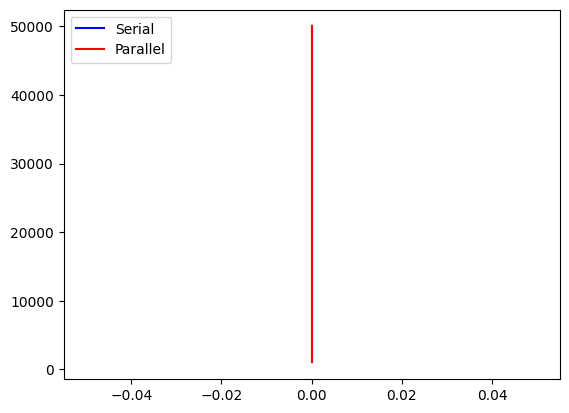

In [51]:
y= numSims
x = serialTimes
z = parallelTimes

plt.plot(x, y, "-b", label="Serial")
plt.plot(x, y, "-r", label="Parallel")
plt.legend(loc="upper left")

plt.show()

# CUDA Kernel (Failed) #

Documentation: https://numba.readthedocs.io/en/stable/cuda/index.html

In [308]:
@cuda.jit
def Prey_Predator(numRuns, numRows, numCols, preySize, predatorSize, prey_results, predator_results, results):
    # Thread id in a 1D block
    # Simulation ID
    id = cuda.threadIdx.x
    
    

    preyPopulation = results[0]
    predatorPopulation = results[1]

    #after simulation
    prey_results[id]=preyPopulation
    predator_results[id]=predatorPopulation

    cuda.syncthreads()

    
    

In [306]:
@cuda.jit(device=True)
def device_simulation(numRuns, numRows, numCols, preySize, predatorSize):
    return Simulation(numRuns, numRows, numCols, preySize, predatorSize)

In [ ]:
# only using 1 block but many threads
# number of threads
num_simulations = 32
num_block = 1

prey_results = cuda.to_device(np.zeros(num_simulations))
# print(prey_results)
predator_results = cuda.to_device(np.zeros(num_simulations))
# print(len(predator_results))


#copy to device
#dprey_results = cuda.device_array_like(prey_results)
#dpredator_results = cuda.device_array_like(predator_results)


#kernel call

numRuns = 5
numRows = 5
numCols = 5
preySize = 10
predatorSize = 5
results=cuda.to_device(np.zeros(2))

Prey_Predator[num_block, num_simulations](numRuns, numRows, numCols, preySize, predatorSize, prey_results, predator_results, results)

#get results to host
prey_results = prey_results.copy_to_host()
predator_results = predator_results.copy_to_host()
print(prey_results)
print(predator_results)